In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [52]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [53]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1229  0.925348  0.885094  0.873457  0.228723  0.939797  0.463716  0.592620   
257   0.134481  0.910330  0.888149  0.975709  0.980542  0.826828  0.935806   
2076  0.154053  0.879206  0.775710  0.238652  0.895560  0.498626  0.341679   
125   0.480000  0.475774  0.235260  0.170124  0.430401  0.009395  0.185222   
159   0.224813  0.916555  0.782566  0.531738  0.907700  0.644310  0.928652   
...        ...       ...       ...       ...       ...       ...       ...   
131   0.490695  0.480148  0.247992  0.173369  0.463329  0.016440  0.184526   
1374  0.530481  0.543237  0.336533  0.217376  0.486779  0.070451  0.264872   
846   0.471872  0.823856  0.593928  0.218617  0.682189  0.236229  0.336032   
1996  0.367701  0.878197  0.797453  0.192553  0.842508  0.287795  0.191642   
2141  0.125070  0.966016  0.828012  0.318085  0.930983  0.572018  0.719880   

            F9        F5        F7     F12       F8  
1229  0.3

In [54]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


# Call the encoder pkl file

In [55]:
import pickle

# Load the encoder model from the saved file
with open("all_pkl_file/Encoder_3.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [56]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



21/21 [==============================] - 0s 869us/step


# tune the RF

In [57]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler(copy=True).fit(dataset)
encoded_X_n=scaler.transform(dataset)
encoded_X_train_n=scaler.transform(X_train)
encoded_X_test_n=scaler.transform(X_test)
encoded_X_train_n

array([[0.51229947, 0.8102288 , 0.54045054, ..., 0.24104661, 0.2749    ,
        0.04683069],
       [0.4571123 , 0.86658816, 0.60097943, ..., 0.13773508, 0.2563    ,
        0.13644704],
       [0.24299465, 0.91806864, 0.94123408, ..., 0.93336059, 0.032045  ,
        0.76455379],
       ...,
       [0.79016043, 0.61053163, 0.3712047 , ..., 0.04341783, 0.2396    ,
        0.14962469],
       [0.12325134, 0.98250336, 0.92497551, ..., 0.58585446, 0.039245  ,
        0.65362802],
       [0.42695187, 0.92681696, 0.91537708, ..., 0.32587899, 0.27045   ,
        0.39090909]])

In [58]:
# train the model with random parameter
from sklearn.ensemble import RandomForestClassifier
# Preparing the regressor and fitting data with some parameters
model = RandomForestClassifier(

    criterion="entropy",
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=25,
    n_estimators=348,
) 

model.fit(encoded_X_train_n, y_train)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=348)

In [59]:
# Finding mean absolute error
preds = model.predict(encoded_X_test_n)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.009036144578313253

In [60]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(encoded_X_n)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(encoded_X_n)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            'n_estimators':trial.suggest_int('n_estimators',50,500),
            'criterion':trial.suggest_categorical('criterion',['gini', 'entropy', 'log_loss']),
            'max_depth':trial.suggest_int('max_depth',20,50),
            'min_samples_split':2,
            'min_samples_leaf':1,
            'max_features':trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'random_state':trial.suggest_int('random_state',0,10),
       
      
        }
    model = RandomForestClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [61]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize',study_name="RF_tune")

[I 2024-02-12 14:15:53,012] A new study created in memory with name: RF_tune


In [62]:

study.optimize(objective, n_trials=20) 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 14:15:59,219] Trial 0 finished with value: 0.012658227848101266 and parameters: {'n_estimators': 351, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'random_state': 7}. Best is trial 0 with value: 0.012658227848101266.


2212


[I 2024-02-12 14:16:07,335] Trial 1 finished with value: 0.0108499095840868 and parameters: {'n_estimators': 396, 'criterion': 'entropy', 'max_depth': 46, 'max_features': 'log2', 'random_state': 1}. Best is trial 1 with value: 0.0108499095840868.


2212


[I 2024-02-12 14:16:19,750] Trial 2 finished with value: 0.013562386980108499 and parameters: {'n_estimators': 267, 'criterion': 'gini', 'max_depth': 23, 'max_features': None, 'random_state': 5}. Best is trial 1 with value: 0.0108499095840868.


2212


[I 2024-02-12 14:16:38,288] Trial 3 finished with value: 0.013110307414104882 and parameters: {'n_estimators': 388, 'criterion': 'gini', 'max_depth': 26, 'max_features': None, 'random_state': 1}. Best is trial 1 with value: 0.0108499095840868.


2212


[I 2024-02-12 14:16:42,840] Trial 4 finished with value: 0.009041591320072333 and parameters: {'n_estimators': 185, 'criterion': 'entropy', 'max_depth': 36, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:16:44,757] Trial 5 finished with value: 0.012658227848101266 and parameters: {'n_estimators': 98, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'random_state': 5}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:16:55,282] Trial 6 finished with value: 0.0108499095840868 and parameters: {'n_estimators': 449, 'criterion': 'log_loss', 'max_depth': 45, 'max_features': 'sqrt', 'random_state': 9}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:16:57,228] Trial 7 finished with value: 0.011301989150090416 and parameters: {'n_estimators': 92, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 'log2', 'random_state': 8}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:05,079] Trial 8 finished with value: 0.0108499095840868 and parameters: {'n_estimators': 372, 'criterion': 'log_loss', 'max_depth': 39, 'max_features': 'log2', 'random_state': 1}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:16,256] Trial 9 finished with value: 0.018535262206148283 and parameters: {'n_estimators': 208, 'criterion': 'log_loss', 'max_depth': 44, 'max_features': None, 'random_state': 6}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:19,792] Trial 10 finished with value: 0.011754068716094032 and parameters: {'n_estimators': 167, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'random_state': 10}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:30,190] Trial 11 finished with value: 0.011301989150090416 and parameters: {'n_estimators': 495, 'criterion': 'entropy', 'max_depth': 36, 'max_features': 'log2', 'random_state': 3}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:36,183] Trial 12 finished with value: 0.0108499095840868 and parameters: {'n_estimators': 286, 'criterion': 'entropy', 'max_depth': 49, 'max_features': 'log2', 'random_state': 3}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:40,050] Trial 13 finished with value: 0.011301989150090416 and parameters: {'n_estimators': 184, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'log2', 'random_state': 0}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:46,055] Trial 14 finished with value: 0.0108499095840868 and parameters: {'n_estimators': 280, 'criterion': 'entropy', 'max_depth': 43, 'max_features': 'sqrt', 'random_state': 3}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:17:55,138] Trial 15 finished with value: 0.009945750452079566 and parameters: {'n_estimators': 426, 'criterion': 'entropy', 'max_depth': 38, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:18:00,104] Trial 16 finished with value: 0.012658227848101266 and parameters: {'n_estimators': 233, 'criterion': 'entropy', 'max_depth': 37, 'max_features': 'sqrt', 'random_state': 10}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:18:01,220] Trial 17 finished with value: 0.014014466546112115 and parameters: {'n_estimators': 51, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:18:08,319] Trial 18 finished with value: 0.011301989150090416 and parameters: {'n_estimators': 334, 'criterion': 'entropy', 'max_depth': 28, 'max_features': 'sqrt', 'random_state': 7}. Best is trial 4 with value: 0.009041591320072333.


2212


[I 2024-02-12 14:18:11,376] Trial 19 finished with value: 0.010397830018083183 and parameters: {'n_estimators': 144, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 8}. Best is trial 4 with value: 0.009041591320072333.


2212
Number of finished trials: 20
Best trial: {'n_estimators': 185, 'criterion': 'entropy', 'max_depth': 36, 'max_features': 'sqrt', 'random_state': 8}


In [63]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["n_estimators", "criterion","max_depth","max_features","random_state"])
fig_study.show()

In [64]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  20
Best trial:
  Value:  0.009041591320072333
  Params: 
    n_estimators: 185
    criterion: entropy
    max_depth: 36
    max_features: sqrt
    random_state: 8


# fit the R-F model

**Process--2 (fit with cross valid)**

In [65]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [66]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(encoded_X_train_n)
target_train = np.array(y_train)

test = np.array(encoded_X_test_n)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(encoded_X_train_n), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    rf_params = study.best_trial.params
    model = RandomForestClassifier(**rf_params)
    model.fit(train_X, train_y)
    # for train accuracy
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

0.012919896640826873


In [67]:
target_test = np.array(y_test)
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)

# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds.round())
print(test_Acc_SVC)

0.9909638554216867


In [68]:
train_Acc=model.score(encoded_X_train_n,y_train)
print(train_Acc)

0.9967700258397932


In [69]:
valid_Acc=accuracy_score(target_train,oof_preds)
print(valid_Acc)

0.9883720930232558


In [70]:
# test_accuracy
test_Acc=model.score(encoded_X_test_n,y_test)
print(test_Acc)

0.9909638554216867


# Evaluation

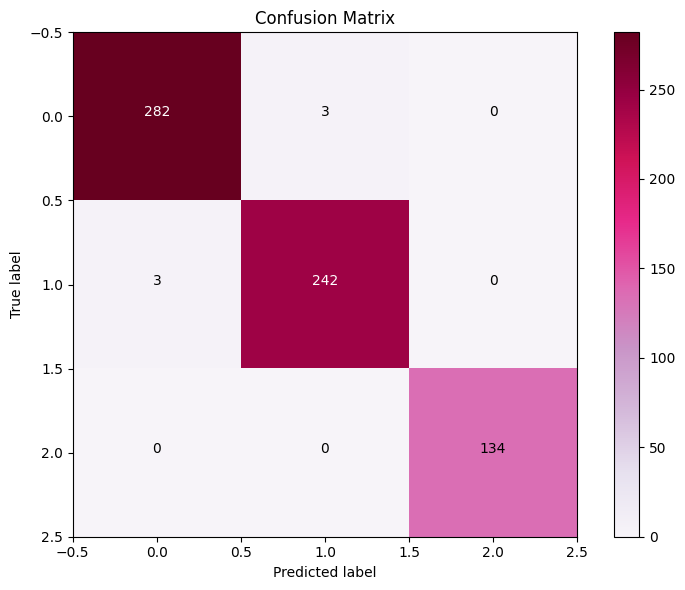

In [71]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
